<a href="https://colab.research.google.com/github/2002sahapriya/SYDE552-Final-Project/blob/master/create-datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install the required libraries

- keras
- dlib
- OpenCV
- tensorflow
- matplotlib

In [1]:
!pip install dlib opencv-python-headless

In [18]:
import os
import urllib.request
from zipfile import ZipFile
import tarfile
import cv2
import dlib
import numpy as np
import matplotlib.pyplot as plt
import bz2
import shutil

# Step 1: Setup and Downloading the Dataset

This part involves downloading the LFW dataset and setting up the environment.

In [9]:
# Function to download and extract the dataset
def download_and_extract(dataset_url, download_path='datasets/normal_face.tgz', extract_path='datasets/normal_faces', remove_file = True):
    if not os.path.exists(extract_path):
        os.makedirs(os.path.dirname(download_path), exist_ok = True)
        print("Downloading dataset...")
        urllib.request.urlretrieve(dataset_url, download_path)
        print("Download complete.")

        # Extract the zip file
        print("Extracting dataset...")
        with tarfile.open(download_path, 'r:gz') as tar:
            tar.extractall(path=os.path.dirname(extract_path))
        print("Extraction complete.")

        # Optionally, remove the zip file
        if remove_file:
            os.remove(download_path)
            print('Tar.gz file removed.')

        print("Dataset ready.")
    else:
        print("Dataset already downloaded and extracted.")

In [11]:
# URL of the LFW dataset
lfw_url = 'http://vis-www.cs.umass.edu/lfw/lfw.tgz'
# Set download to false if the download is not needed
download = True
if download:
    download_and_extract(dataset_url = lfw_url, remove_file = False)
    download = False

Download complete.
Extracting dataset...
Extraction complete.
Dataset ready.


In [15]:
# Function to load and display images from the dataset
def load_and_display_images(base_path, num_images_to_display=3):
    # Initialize an empty list to hold the image paths
    image_paths = []

    # Walk through the directory tree to find image files
    for root, dirs, files in os.walk(base_path):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                # Append the full path of each image to the list
                image_paths.append(os.path.join(root, file))

    # Display the first few images as specified by num_images_to_display
    plt.figure(figsize=(15, 5))
    for i, image_path in enumerate(image_paths[:num_images_to_display]):
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
        plt.subplot(1, num_images_to_display, i+1)
        plt.imshow(image)
        plt.title(f'Image {i+1}')
        plt.xticks([])
        plt.yticks([])
    plt.show()

    # Return the array of image paths for further use
    return image_paths

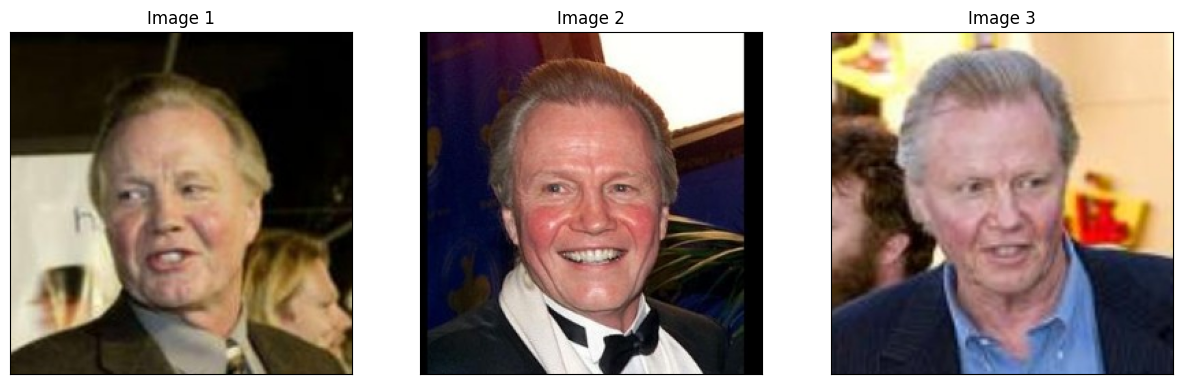

13233


In [67]:
# Call the function to load images and display them
image_paths = load_and_display_images('datasets/lfw')

print(len(image_paths))

# Step 2: Setting up Facial Detection and Blurring Features

This parts sets up `dlib` for facial detection and defines the blurring function.

### Explanation:
1. **Mask Creation**: A mask is created to specify which area of the image will be blurred. Initially, the mask is entirely black (`0` values indicate no masking).
2. **Convex Hull**: Computes the convex hull of the specified points, which creates a minimal convex boundary that encloses all the points. This hull is used to define the area on the mask that will correspond to the facial feature to blur.
3. **Blurring and Masking**: First, we apply a Gaussian blur to the entire image. It then uses the mask to combine the blurred version of the feature area with the original image. The mask ensures that only the specified feature region is blurred, leaving the rest of the image unaffected.
4. **Bitwise Operations**: `cv2.bitwise-and` and `cv2.bitwise_not` are used to isolate and the merge the blurred and non-blurred parts of the image. This approach ensures that the blurring effect is cleanly applied only to the desired facial feature.

In [19]:
def download_dlib_model(url, bz2_filename, dat_filename, remove_file = False):
    # Check if the decompressed .dat file already exists
    if not os.path.isfile(dat_filename):
        # Check if the compressed .bz2 file already exists
        if not os.path.isfile(bz2_filename):
            print(f"Downloading {bz2_filename}...")
            urllib.request.urlretrieve(url, bz2_filename)
            print(f"Downloaded {bz2_filename}.")

        # Decompress the .bz2 file to get the .dat file
        print(f"Decompressing {bz2_filename} to get {dat_filename}...")
        with bz2.BZ2File(bz2_filename, 'rb') as f_in:
            with open(dat_filename, 'wb') as f_out:
                shutil.copyfileobj(f_in, f_out)
        print(f"Decompressed to {dat_filename}.")

        # Optionally, remove the .bz2 file after decompression
        if remove_file:
          os.remove(bz2_filename)
          print(f"Removed compressed file {bz2_filename}.")
    else:
        print(f"{dat_filename} already exists. No download needed.")

# URL to the dlib pre-trained facial landmark predictor
dlib_model_url = "http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2"
# Filename of the compressed model
compressed_file_name = "shape_predictor_68_face_landmarks.dat.bz2"
# Filename of the decompressed model
model_file_name = "shape_predictor_68_face_landmarks.dat"

# Call the function to download and decompress the model
download_dlib_model(dlib_model_url, compressed_file_name, model_file_name)

Downloaded shape_predictor_68_face_landmarks.dat.bz2.
Decompressing shape_predictor_68_face_landmarks.dat.bz2 to get shape_predictor_68_face_landmarks.dat...
Decompressed to shape_predictor_68_face_landmarks.dat.
Removed compressed file shape_predictor_68_face_landmarks.dat.bz2.


In [63]:
# Load the pre-trained face detector and facial landmark predictor
detector = dlib.get_frontal_face_detector()
# Path to the facial landmark predictor
predictor_path = 'shape_predictor_68_face_landmarks.dat' # have to download this file
# Load the facial landmark predictor
predictor = dlib.shape_predictor(predictor_path)

import numpy as np
import cv2

def blur_feature(image, landmarks, feature_indices, feature_type):
    '''
    Applies a blurring effect to specific features on the face by fitting an ellipse around the landmarks.

    Parameters:
    image (numpy.ndarray): The original image.
    landmarks (dlib.full_object_detection): Facial landmarks detected by dlib predictor.
    feature_indices (list of int): Indices of the landmarks that define the region to blur.
    feature_type (str): The type of feature to blur ('eyes', 'nose', 'mouth').

    Returns:
    numpy.ndarray: The image with the specified feature blurred.
    '''

    # Create a mask to match the image dimensions, single channel for grayscale
    mask = np.zeros_like(image[:, :, 0])

    # Collect points from the landmarks based on the provided indices
    feature_points = np.array([(landmarks.part(n).x, landmarks.part(n).y) for n in feature_indices], dtype=np.int32)

    # Generate a convex hull (the smallest convex polygon containing all points) for the feature
    hull = cv2.convexHull(feature_points)

    # Fit a rotated rectangle to the convex hull of the feature points, which provides a better fit than an ellipse
    rect = cv2.minAreaRect(hull)
    box = cv2.boxPoints(rect)
    box = np.int32(box)

    # Depending on the feature, adjust the box dimensions
    if feature_type in ['eyes', 'mouth']:
        # For the eyes and mouth, expand the box horizontally
        center, size, angle = rect
        size = (size[0] * 1.4, size[1] * 1.2)  # Increase the size a bit for better coverage
        rect = (center, size, angle)
        box = cv2.boxPoints(rect)
        box = np.int32(box)

    elif feature_type == 'nose':
        # For the nose, expand the box vertically
        center, size, angle = rect
        size = (size[0] * 1.2, size[1] * 1.4)
        rect = (center, size, angle)
        box = cv2.boxPoints(rect)
        box = np.int32(box)

    # Draw the fitted box on the mask
    cv2.drawContours(mask, [box], 0, (255, 255, 255), -1)

    # Apply Gaussian blur to the image
    blurred_image = cv2.GaussianBlur(image, (51, 51), 0)

    # Combine the original and blurred images using the mask
    combined_image = np.where(mask[..., None].astype(bool), blurred_image, image)

    return combined_image

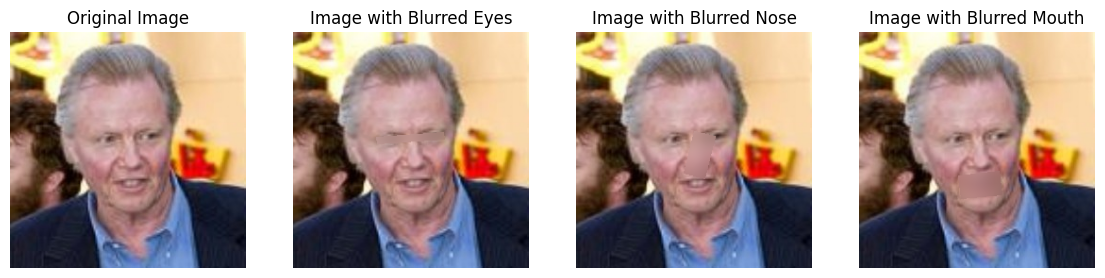

In [64]:
# Load the pre-trained face detector and facial landmark predictor
detector = dlib.get_frontal_face_detector()
predictor_path = 'shape_predictor_68_face_landmarks.dat'  # Path to the facial landmark predictor file
predictor = dlib.shape_predictor(predictor_path)  # Load the facial landmark predictor

# Assuming image_paths is already defined and contains paths to the images
selected_image_path = image_paths[2]  # Take the first image for demonstration
image = cv2.imread(selected_image_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Detect faces in the image
faces = detector(gray)
for face in faces:
    landmarks = predictor(gray, face)

    # Example feature indices for the eyes (left and right)
    eyes_indices = list(range(36, 42)) + list(range(42, 48))
    nose_indices = list(range(27, 36))
    mouth_indices = list(range(48, 68))

    # Blur the eyes in the image
    image_with_blurred_eyes = blur_feature(image.copy(), landmarks, eyes_indices, 'eyes')
    # Blur the nose in the image
    image_with_blurred_nose = blur_feature(image.copy(), landmarks, nose_indices, 'nose')
    #Blur the mouth in the image
    image_with_blurred_mouth = blur_feature(image.copy(), landmarks, mouth_indices, 'mouth')

    # Convert from BGR to RGB for displaying
    original_image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    blurred_eyes_image_rgb = cv2.cvtColor(image_with_blurred_eyes, cv2.COLOR_BGR2RGB) # for eyes
    blurred_nose_image_rgb = cv2.cvtColor(image_with_blurred_nose, cv2.COLOR_BGR2RGB) # for nose
    blurred_mouth_image_rgb = cv2.cvtColor(image_with_blurred_mouth, cv2.COLOR_BGR2RGB) # for mouth

    # Display the original and blurred images side by side
    plt.figure(figsize=(14, 12))

    # Display original image
    plt.subplot(1, 4, 1)
    plt.imshow(original_image_rgb)
    plt.title('Original Image')
    plt.axis('off')

    # Display image with blurred eyes
    plt.subplot(1, 4, 2)
    plt.imshow(blurred_eyes_image_rgb)
    plt.title('Image with Blurred Eyes')
    plt.axis('off')

    # Display image with blurred nose
    plt.subplot(1, 4, 3)
    plt.imshow(blurred_nose_image_rgb)
    plt.title('Image with Blurred Nose')
    plt.axis('off')

    # Display image with blurred mouth
    plt.subplot(1, 4, 4)
    plt.imshow(blurred_mouth_image_rgb)
    plt.title('Image with Blurred Mouth')
    plt.axis('off')

    plt.show()
    break  # Only process the first face found for demonstration purposes

# Step 3: Processing Images to Create Modified Datasets

This part processes each image to blur specific facial features.

In [74]:

def delete_non_empty_directory(dir_path):
    # Check if the directory exists
    if os.path.exists(dir_path):
        # Remove the directory and all its contents
        shutil.rmtree(dir_path)
        print(f"Directory '{dir_path}' has been removed along with all its contents.")
    else:
        print(f"The directory '{dir_path}' does not exist.")

# Usage
directory_to_delete = "datasets/blurred_eyes"
delete_non_empty_directory(directory_to_delete)

directory_to_delete = "datasets/blurred_nose"
delete_non_empty_directory(directory_to_delete)

directory_to_delete = "datasets/blurred_mouth"
delete_non_empty_directory(directory_to_delete)

Directory 'datasets/blurred_eyes' has been removed along with all its contents.
Directory 'datasets/blurred_nose' has been removed along with all its contents.
Directory 'datasets/blurred_mouth' has been removed along with all its contents.


In [75]:
# Directory of the dataset and output directories
data_dir = 'datasets/lfw' # Path where the original dataset is stored
output_dirs = {
    'eyes': 'datasets/blurred_eyes', # Directory to store images with blurred eyes
    'nose': 'datasets/blurred_nose',  # Directory to store images with blurred nose
    'mouth': 'datasets/blurred_mouth' # Director to store images with blurred mouth
}

# Create the output directories if they do not exist
for path in output_dirs.values():
    os.makedirs(path, exist_ok=True)

# Define the landmark indices for each facial feature based on the 68-point model
feature_indices = {
    'eyes': list(range(36, 42)) + list(range(42, 48)), # Indices for left and right eyes
    'nose': list(range(27, 36)), # Indices for the nose
    'mouth': list(range(48, 68)) # Indices for the mouth
}

# Process each image using paths from image_paths
for image_path in image_paths:
    image = cv2.imread(image_path) # Read the image
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # Convert the image to grayscale for detection

    # Detect faces in the image
    faces = detector(gray)
    for face in faces:
        landmarks = predictor(gray, face) # Detect landmarks for each face

        # Process each defined feature (eyes, nose, mouth)
        for feature, indices in feature_indices.items():
            # Blur the specific feature on the image
            modified_image = blur_feature(image.copy(), landmarks, indices, feature)
            # Define the output path for the blurred image
            output_dir = output_dirs[feature]
            os.makedirs(output_dir, exist_ok=True)  # Ensure output directory exists
            output_path = os.path.join(output_dir, os.path.basename(image_path))
            # Save the modified image to the appropriate directory
            cv2.imwrite(output_path, modified_image)

print("Modified datasets created.")

Modified datasets created.


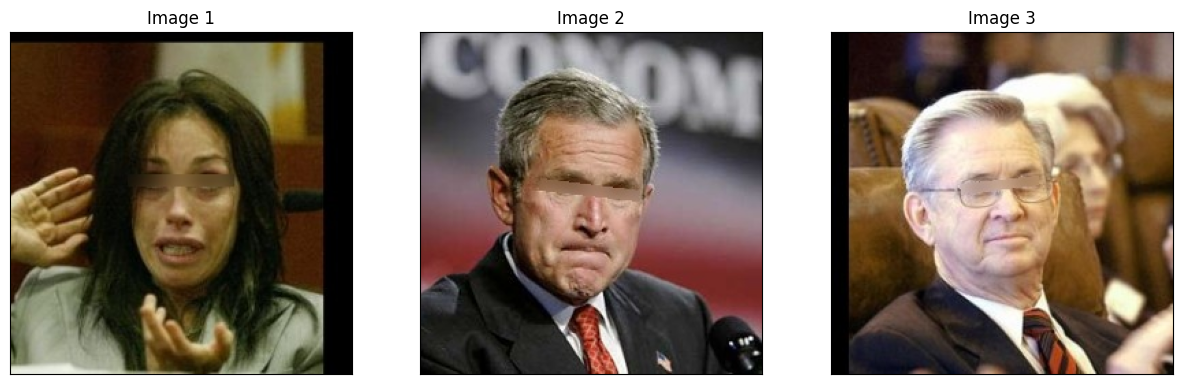

-95


In [85]:
# Load and display image for blurred eyes
blurred_eyes_paths = load_and_display_images('datasets/blurred_eyes')
print(len(blurred_eyes_paths) - len(image_paths))

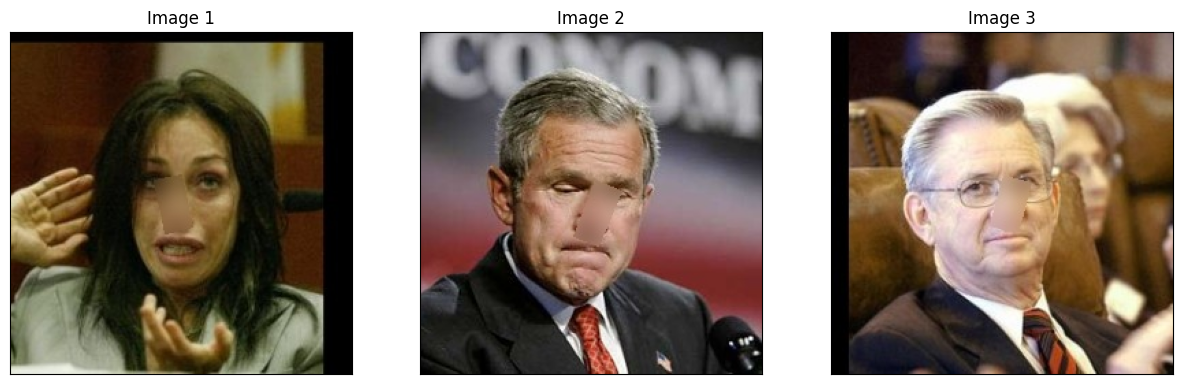

-95


In [86]:
# Load and display image for blurred nose
blurred_nose_paths = load_and_display_images('datasets/blurred_nose')
print(len(blurred_nose_paths) - len(image_paths))

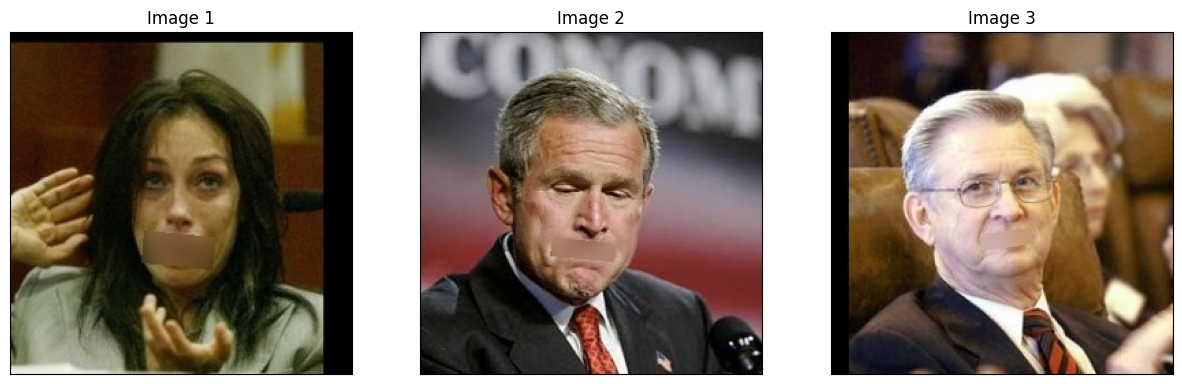

-95


In [87]:
# Load and display image for blurred mouth
blurred_mouth_paths = load_and_display_images('datasets/blurred_mouth')
print(len(blurred_mouth_paths) - len(image_paths))

# Step 4: Save the datasets

In [77]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [78]:
dataset_path = '/content/drive/My Drive/SYDE-552-Final/datasets'

In [79]:
# Clone the github repo
!git clone https://github.com/2002sahapriya/SYDE552-Final-Project.git

Cloning into 'SYDE552-Final-Project'...
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 7 (delta 0), reused 4 (delta 0), pack-reused 0
Receiving objects: 100% (7/7), 4.66 KiB | 2.33 MiB/s, done.


In [80]:
# Copy datasets to the repo
!cp '/content/drive/My Drive/SYDE-552-Final/datasets' '/content/SYDE552-Final-Projec/'

cp: cannot stat '/content/drive/My Drive/SYDE-552-Final/datasets': No such file or directory


In [89]:
!git config --global user.email "2002sahapriya@gmail.com"
!git config --global user.name "2002sahapriya"

# Install Git LFS for large files
!curl -s https://packagecloud.io/install/repositories/github/git-lfs/script.deb.sh | sudo bash
!sudo apt-get install git-lfs

# Initialize Git and Git LFS
!git init
!git lfs install

# Add your GitHub repo as the remote
!git remote add origin https://github.com/2002sahapriya/SYDE552-Final-Project.git

# Add your files to the staging area
!git add datasets/

# Make your commit
!git commit -m "Added datasets"

# Set the path to your GitHub repo and push
!git push https://github.com/2002sahapriya/SYDE552-Final-Project.git

# Replace `your-token` with the personal access token you generated on GitHub

Streaming output truncated to the last 5000 lines.
 create mode 100644 datasets/blurred_nose/Michael_Chang_0006.jpg
 create mode 100644 datasets/blurred_nose/Michael_Chang_0007.jpg
 create mode 100644 datasets/blurred_nose/Michael_Chang_0008.jpg
 create mode 100644 datasets/blurred_nose/Michael_Chertoff_0001.jpg
 create mode 100644 datasets/blurred_nose/Michael_Chiklis_0001.jpg
 create mode 100644 datasets/blurred_nose/Michael_Chiklis_0002.jpg
 create mode 100644 datasets/blurred_nose/Michael_Chiklis_0003.jpg
 create mode 100644 datasets/blurred_nose/Michael_Chiklis_0004.jpg
 create mode 100644 datasets/blurred_nose/Michael_Chiklis_0005.jpg
 create mode 100644 datasets/blurred_nose/Michael_Clarke_Duncan_0001.jpg
 create mode 100644 datasets/blurred_nose/Michael_DeMinico_0001.jpg
 create mode 100644 datasets/blurred_nose/Michael_Dell_0001.jpg
 create mode 100644 datasets/blurred_nose/Michael_Denzel_0001.jpg
 create mode 100644 datasets/blurred_nose/Michael_Deutsch_0001.jpg
 create mode 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

